## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2

import scipy.ndimage as ndi
from scipy.spatial.distance import cdist
from scipy.interpolate import splprep, splev
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter
from skimage.morphology import skeletonize
from sklearn.cluster import DBSCAN

## Functions

#### Histogram functions

In [4]:
def rgb_histogram(img, bins=32):
    rgb = img.reshape(-1,3)
    if rgb.max() > 1:
        rgb = rgb / 255.0
    hist, edges = np.histogramdd(rgb, bins=(bins,bins,bins), range=((0,1),(0,1),(0,1)))
    return hist, edges

def smooth_histogram(hist, sigma=1):
    return gaussian_filter(hist, sigma=sigma)

def plot_rgb_histogram(hist, edges, alpha=0.8, min_counts = 5):
     # 3D scatter plot of RGB histogram bin centers

    # Centers of bins
    centers = [0.5 * (e[:-1] + e[1:]) for e in edges]
    R, G, B = np.meshgrid(*centers, indexing='ij')

    pts = np.column_stack([R.ravel(), G.ravel(), B.ravel()])
    counts = hist.ravel()

    mask = counts >= min_counts

    pts = pts[mask]
    counts = counts[mask]
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    s = 5 + np.sqrt(counts)

    ax.scatter( pts[:,0], pts[:,1], pts[:,2], c=pts, s=s, alpha=alpha )
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")
    ax.set_title("RGB Histogram")

    return fig, ax

#### Skeletonize function

About skimage.morphology.skeletonize:

The method of [Lee94] uses an octree data structure to examine a 3x3x3 neighborhood of a pixel. The algorithm proceeds by iteratively sweeping over the image, and removing pixels at each iteration until the image stops changing. Each iteration consists of two steps: first, a list of candidates for removal is assembled; then pixels from this list are rechecked sequentially, to better preserve connectivity of the image.

The algorithm this function implements is different from the algorithms used by either skeletonize or medial_axis, thus for 2D images the results produced by this function are generally different.

References

[Lee94]
T.-C. Lee, R.L. Kashyap and C.-N. Chu, Building skeleton models via 3-D medial surface/axis thinning algorithms. Computer Vision, Graphics, and Image Processing, 56(6):462-478, 1994.

In [8]:
def skeletonize_hist(hist, threshold_ratio=0.1):
    mask = hist > hist.max() * threshold_ratio    # Only take into account bins above a threshold
    skeleton = skeletonize(mask.astype(np.uint8)) # Skeletonize 
    coords = np.array(np.nonzero(skeleton)).T     # histogram bin the voxel belongs to along each axis (N, 3)
    return coords


def coords_to_rgb(coords, edges):
    # Map histogram bin coordinates back to RGB values in [0,1].

    r = edges[0][coords[:,0]]  # left boundary of histogram bin the voxel belongs to along R
    g = edges[1][coords[:,1]]
    b = edges[2][coords[:,2]]
    rgb = np.stack([r,g,b], axis=1) # combine (N, 3)
    return rgb

def plot_rgb_skeleton(rgb_coords):
    # Plot skeleton points in RGB space
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(rgb_coords[:,0], rgb_coords[:,1], rgb_coords[:,2], c=rgb_coords, s=10, alpha=0.5)
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(0,1)
    return fig, ax


def rgb_skeleton(img, bins=32, sigma=1, threshold_ratio=0.1, plot = True):
    # Everything combined
    hist, edges = rgb_histogram(img, bins=bins) # RGB histogram of pixels 
    hist_smooth = smooth_histogram(hist, sigma=sigma) # Gaussian smoothing of the histogram
    coords = skeletonize_hist(hist_smooth, threshold_ratio=threshold_ratio) # Skeleton points (in histogram bins)
    rgb_coords = coords_to_rgb(coords, edges) # Skeleton points (in RGB coordinates)

    if plot == True:
        fig, ax = plot_rgb_skeleton(rgb_coords) # plotting function
        plt.show()
    return rgb_coords



In [10]:
def closest_point(point, branch):
    # Euclidean distances in RGB space
    dists = np.linalg.norm(branch - point, axis=1)
    idx = np.argmin(dists)
    return branch[idx], idx, dists[idx]


def mark(ax, x, y, label, color, z=None):
    if z is None:  # 2D
        ax.scatter(x, y, c=color, s=20, marker='x')
        ax.annotate(
            label,
            (x, y),
            xytext=(5, 5),
            textcoords="offset points",
            color=color,
            fontsize=11
        )
    else:  # 3D
        ax.scatter(x, y, z, c=color, s=20, marker='x')
        ax.text(
            x, y, z,
            label,
            color=color,
            fontsize=11
        )

## Import Fuji:
- Selecting Kubelka-Munk values: $R_0, R_1, R_g$


In [13]:
# Load in Red Fuji
img = Image.open("red_fuji.jpg") # Shape (x,y,RGB)
img = np.array(img)/255.0

height, width, _ = img.shape

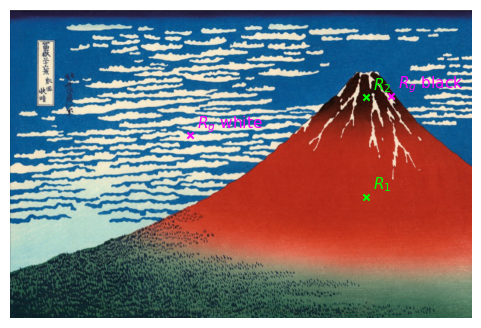

In [15]:
%matplotlib inline

# Indices R1, R0, Rg_black, Rg_white
indx_min = np.array(np.unravel_index(np.argmin(np.sum(img, axis = 2)), (height, width))) #Rg_black
indx_max = np.array(np.unravel_index(np.argmax(np.sum(img, axis = 2)), (height, width))) #Rg_white

y, x = indx_min 
v, u = indx_max
x0 = 608 
y0 = 149
h = 170

Rg_black = img[y,x,:] # minimum value image / closest to (0,0,0)
Rg_white = img[v,u,:] # maximum value image / closest to (1,1,1)
R0 = img[y0, x0, :] # A point that I assume has thickness x and is on Rg_black
R1 = img[y0+h, x0, :] # A point that I assume has thickness x and is on Rg_white

# Plot
fig, ax = plt.subplots(1, figsize = (12,4))
ax.imshow(img)

mark(ax, x, y, r"$R_g$ black", 'magenta')
mark(ax, u, v, r"$R_g$ white", 'magenta')
mark(ax, x0, y0+h, r"$R_1$", 'lime')
mark(ax, x0, y0, r"$R_2$", 'lime')

ax.axis('off')
plt.show()

### Plot RGB histogram

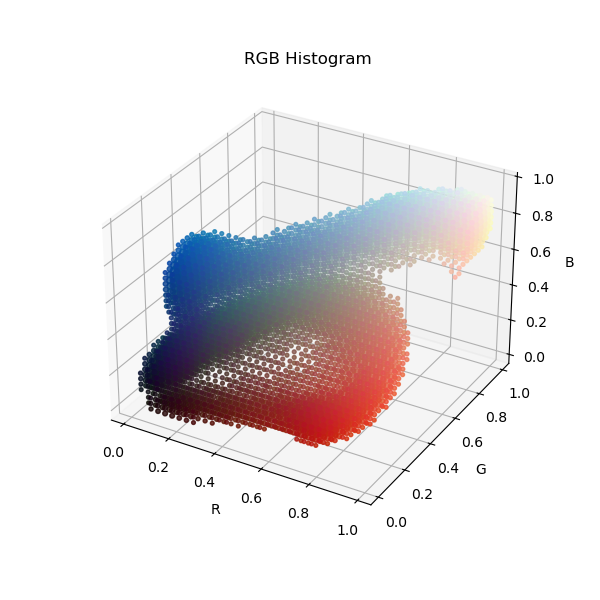

In [18]:
%matplotlib widget

hist, edges = rgb_histogram(img, bins = 32)
smooth_hist = smooth_histogram(hist)
fig, ax = plot_rgb_histogram(smooth_hist, edges)
plt.show()

### Plot skeleton points

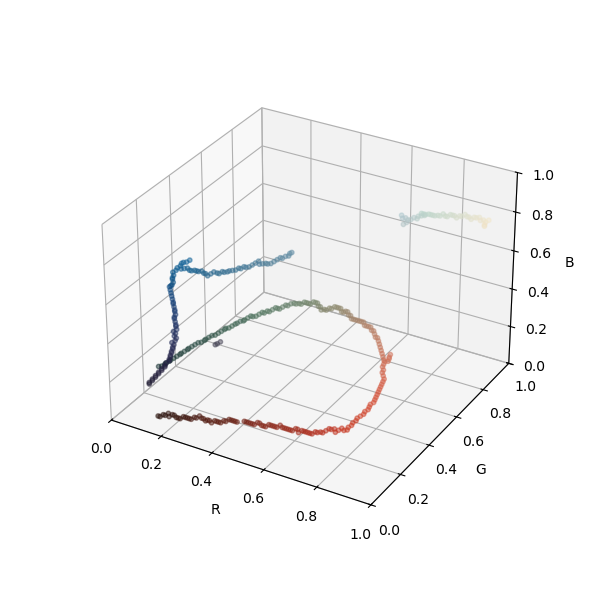

In [21]:
# Change these numbers to get an accurate representation
bins=128
sigma=1
threshold_ratio=0.005

rgb_coords_full = rgb_skeleton(img, bins = bins, sigma = sigma, threshold_ratio = threshold_ratio)
#rgb_coords_rg = rgb_skeleton(red_green, bins = bins, sigma = sigma, threshold_ratio = threshold_ratio) # selected gradient

### Select branches

About sklearn.cluster.DBSCAN

Perform DBSCAN clustering from vector array or distance matrix.

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. This algorithm is particularly good for data which contains clusters of similar density and can find clusters of arbitrary shape.

Unlike K-means, DBSCAN does not require specifying the number of clusters in advance and can identify outliers as noise points.

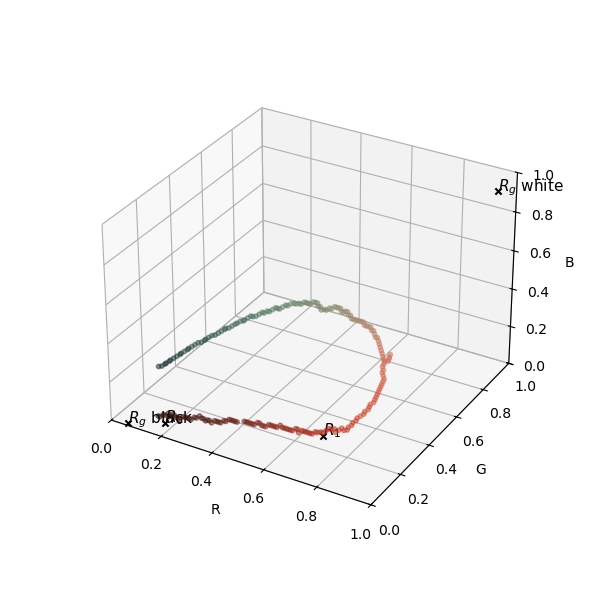

In [23]:
%matplotlib widget

# coords_rgb: Nx3 array of skeleton points in RGB space
clustering = DBSCAN(eps=0.05, min_samples=5).fit(rgb_coords_full) # clusters
labels = clustering.labels_  # -1 = noise, 0,1,... = clusters

# Collect points per cluster
branches = [rgb_coords_full[labels==i] for i in np.unique(labels) if i != -1]

idx_max = np.argmax(np.sum(branches[1], axis = 1))
point_max = branches[1][idx_max, :]

R0_branch, idx_R0, _ = closest_point(R0, branches[1])
R1_branch, idx_R1, _ = closest_point(R1, branches[1])

fig, ax = plot_rgb_skeleton(branches[1])

mark(ax, Rg_black[0], Rg_black[1], r"$R_g$ black", 'k', z = Rg_black[2])
mark(ax, Rg_white[0], Rg_white[1], r"$R_g$ white", 'k', z = Rg_white[2])
mark(ax, R0[0], R0[1], r"$R_0$", 'k', z = R0[2])
mark(ax, R1[0], R1[1], r"$R_1$", 'k', z = R1[2])

plt.show()